In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm_notebook
np.set_printoptions(suppress=True)
from sklearn import preprocessing
from tqdm import tqdm
import decimal
from random import shuffle
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
import gc
import datetime
import os
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
import random

In [2]:
#Always seed the randomness of this universe
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
seed_everything(seed=51)

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
%%time
#train_identity
train_identity = dd.read_csv('../input/train_identity.csv')
train_identity = train_identity.compute()
train_identity = train_identity.reset_index(drop=True)
print("train_identity finished")
#test_identity
test_identity = dd.read_csv('../input/test_identity.csv')
test_identity = test_identity.compute()
test_identity = test_identity.reset_index(drop=True)
print("test_identity finished")
#train_transaction
train_transaction = dd.read_csv('../input/train_transaction.csv')
train_transaction = train_transaction.compute()
train_transaction = train_transaction.reset_index(drop=True)
print("train_transaction finished")
#test_transaction
test_transaction = dd.read_csv('../input/test_transaction.csv')
test_transaction = test_transaction.compute()
test_transaction = test_transaction.reset_index(drop=True)
print("test_transaction finished")
#sample_submission
sample_submission = pd.read_csv('../input/sample_submission.csv')
print(sample_submission.shape)

train_identity finished
test_identity finished
train_transaction finished
test_transaction finished
(506691, 2)
CPU times: user 1min 7s, sys: 11.1 s, total: 1min 18s
Wall time: 27 s


In [6]:
print(train_identity.shape,test_identity.shape,train_transaction.shape,test_transaction.shape)

(144233, 41) (141907, 41) (590540, 394) (506691, 393)


In [7]:
%%time
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

CPU times: user 7.67 s, sys: 7.22 s, total: 14.9 s
Wall time: 14.9 s


In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
del train_identity,test_identity,train_transaction,test_transaction
gc.collect()

154

In [10]:
%%time
#train = reduce_mem_usage(train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [11]:
%%time
#test = reduce_mem_usage(test)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [12]:
print(train.shape,test.shape)

(590540, 434) (506691, 433)


In [13]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [14]:
for df in tqdm([train, test]):
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['month'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['weekofyear'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['dayofyear'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['hour'] = df['DT'].dt.hour
    df['dayofweek'] = df['DT'].dt.dayofweek
    df['day'] = df['DT'].dt.day

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


In [15]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DT,month,weekofyear,dayofyear,hour,dayofweek,day
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-01 00:00:00,12,48,335,0,4,1
1,2987001,0,86401,29.0,W,2755,404.0,150.0,m

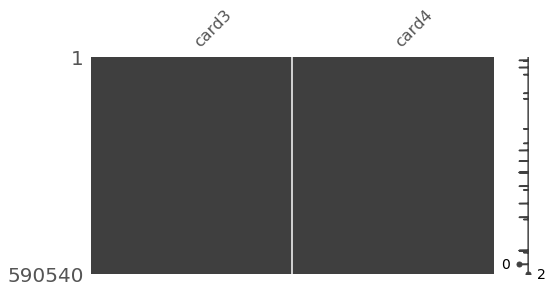

In [16]:
msno.matrix(train[['card3','card4']],figsize=(8,4))
plt.show()

# TransactionID

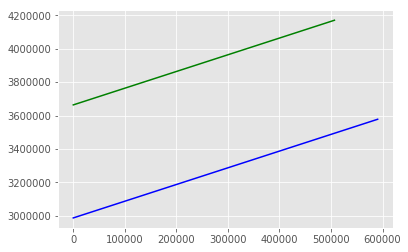

In [17]:
train['TransactionID'].plot(kind='line',color = 'blue')
test['TransactionID'].plot(kind='line', color = 'green')
plt.show()

In [18]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DT,month,weekofyear,dayofyear,hour,dayofweek,day
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-01 00:00:00,12,48,335,0,4,1
1,2987001,0,86401,29.0,W,2755,404.0,150.0,m

In [19]:
def less_category(x):
    if x in temp:
        return x
    else:
        return 999999

In [20]:
def less_category_str(x):
    if x in temp:
        return x
    else:
        return '999999'

# card1

In [21]:
column_name = 'card1'
train[column_name].head()

0    13926
1     2755
2     4663
3    18132
4     4497
Name: card1, dtype: int64

In [22]:
train[column_name].isnull().sum(),test[column_name].isnull().sum()

(0, 0)

In [23]:
train[column_name].nunique(),test[column_name].nunique()

(13553, 13244)

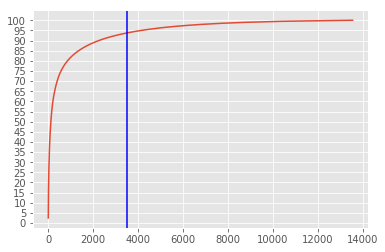

In [24]:
pd.Series(train[column_name].value_counts(normalize=True,dropna=False)*100).cumsum().reset_index(drop=True).plot(kind='line')
plt.axvline(3500,color='blue')
plt.yticks(range(0,101,5))
plt.show()

In [25]:
temp = list(pd.concat([train[column_name],test[column_name]],axis= 0).value_counts().head(3250).index)
print(len(temp))
temp = [x for x in temp if x in train[column_name].unique()]
temp = [x for x in temp if x in test[column_name].unique()]
print(len(temp))

3250
3213


In [26]:
train[column_name] = train[column_name].progress_apply(less_category)
test[column_name] = test[column_name].progress_apply(less_category)

100%|██████████| 506691/506691 [00:04<00:00, 119413.19it/s]


In [27]:
train[column_name + '_999999'] = train[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)
test[column_name + '_999999'] = test[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)

100%|██████████| 506691/506691 [00:00<00:00, 933741.45it/s] 


In [28]:
train[column_name].nunique(),test[column_name].nunique()

(3214, 3214)

In [29]:
temp = pd.concat([train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False),train[column_name].value_counts()],axis=1)
temp = temp.sort_values(by = 'isFraud',ascending= False)

In [30]:
temp['fraud_count'] = temp['isFraud'] * temp[column_name]

In [31]:
mask1 = (temp['isFraud'] > 0.20) & (temp[column_name] > 30)

In [32]:
fraudulent_card = [x for x in list(temp[mask1].index)]

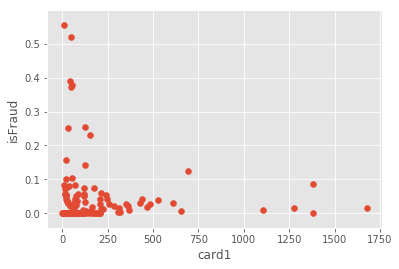

In [33]:
plt.scatter(x =column_name,y='isFraud' ,data=temp.sample(200))
plt.xlabel(column_name)
plt.ylabel('isFraud')
plt.show()

In [34]:
train[column_name + '_fraudulent'] = train[column_name].progress_apply(lambda x: 1 if x in fraudulent_card else 0)
test[column_name + '_fraudulent'] = test[column_name].progress_apply(lambda x: 1 if x in fraudulent_card else 0)

100%|██████████| 506691/506691 [00:00<00:00, 562780.18it/s]


In [35]:
le = LabelEncoder()
le.fit(list(train[column_name]) + list(test[column_name]))
train[column_name] = le.transform(train[column_name])
test[column_name] = le.transform(test[column_name])

In [36]:
train[column_name].head()

0    2386
1     315
2     658
3    3165
4     631
Name: card1, dtype: int64

# card2

In [37]:
column_name = 'card2'
train[column_name].head()

0      NaN
1    404.0
2    490.0
3    567.0
4    514.0
Name: card2, dtype: float64

In [38]:
train[column_name].isnull().sum(),test[column_name].isnull().sum()

(8933, 8654)

In [39]:
train[column_name].nunique(),test[column_name].nunique()

(500, 497)

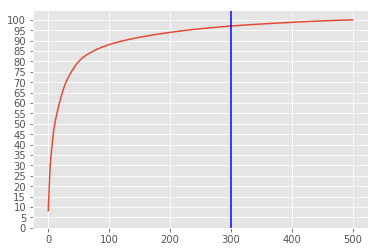

In [40]:
pd.Series(train[column_name].value_counts(normalize=True,dropna=False)*100).cumsum().reset_index(drop=True).plot(kind='line')
plt.axvline(300,color='blue')
plt.yticks(range(0,101,5))
plt.show()

In [41]:
temp = list(pd.concat([train[column_name],test[column_name]],axis= 0).value_counts().head(300).index)
print(len(temp))
temp = [x for x in temp if x in train[column_name].unique()]
temp = [x for x in temp if x in test[column_name].unique()]
print(len(temp))

300
297


In [42]:
train[column_name] = train[column_name].progress_apply(less_category)
test[column_name] = test[column_name].progress_apply(less_category)

100%|██████████| 506691/506691 [00:00<00:00, 710851.64it/s]


In [43]:
train[column_name + '_999999'] = train[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)
test[column_name + '_999999'] = test[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)

100%|██████████| 506691/506691 [00:00<00:00, 938565.37it/s] 


In [44]:
train[column_name].nunique(),test[column_name].nunique()

(298, 298)

In [45]:
temp = pd.concat([train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False),train[column_name].value_counts()],axis=1)
temp = temp.sort_values(by = 'isFraud',ascending= False)

In [46]:
temp['fraud_count'] = temp['isFraud'] * temp[column_name]

In [47]:
temp.head(10)

,isFraud,card2,fraud_count
405.0,0.403509,228,92.0
176.0,0.360624,513,185.0
482.0,0.327381,168,55.0
311.0,0.280277,289,81.0
104.0,0.248011,754,187.0
324.0,0.241692,331,80.0
177.0,0.241169,1642,396.0
142.0,0.240356,1685,405.0
130.0,0.239257,2746,657.0
141.0,0.236559,279,66.0


In [48]:
mask1 = (temp['isFraud'] > 0.10) & (temp[column_name] > 30)

In [49]:
fraudulent_card = [x for x in list(temp[mask1].index)]

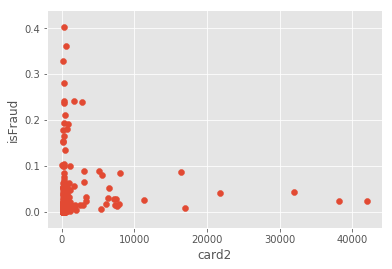

In [50]:
plt.scatter(x =column_name,y='isFraud' ,data=temp.sample(200))
plt.xlabel(column_name)
plt.ylabel('isFraud')
plt.show()

In [51]:
train[column_name + '_fraudulent'] = train[column_name].progress_apply(lambda x: 1 if x in fraudulent_card else 0)
test[column_name + '_fraudulent'] = test[column_name].progress_apply(lambda x: 1 if x in fraudulent_card else 0)

100%|██████████| 506691/506691 [00:00<00:00, 773243.37it/s]


In [52]:
le = LabelEncoder()
le.fit(list(train[column_name]) + list(test[column_name]))
train[column_name] = le.transform(train[column_name])
test[column_name] = le.transform(test[column_name])

In [53]:
train[column_name + '_fraudulent'].sum()

18743

# card3

In [54]:
column_name = 'card3'
train[column_name].head()

0    150.0
1    150.0
2    150.0
3    150.0
4    150.0
Name: card3, dtype: float64

In [55]:
train[column_name].isnull().sum(),test[column_name].isnull().sum()

(1565, 3002)

In [56]:
train[column_name].fillna(150.0,inplace=True)
test[column_name].fillna(150.0,inplace=True)

In [57]:
train[column_name].nunique(),test[column_name].nunique()

(114, 115)

In [58]:
train[column_name].value_counts(normalize=True,dropna=False).head(10)*100

150.0    88.537948
185.0     9.541437
106.0     0.266028
146.0     0.212009
144.0     0.212009
117.0     0.162902
143.0     0.152234
119.0     0.127002
102.0     0.077895
147.0     0.066041
Name: card3, dtype: float64

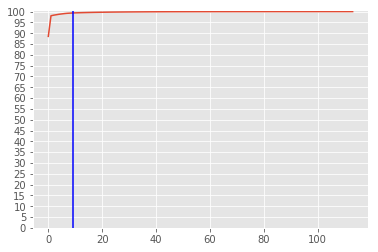

In [59]:
pd.Series(train[column_name].value_counts(normalize=True,dropna=False)*100).cumsum().reset_index(drop=True).plot(kind='line')
plt.axvline(9,color='blue')
plt.yticks(range(0,101,5))
plt.show()

In [60]:
temp = list(pd.concat([train[column_name],test[column_name]],axis= 0).value_counts(dropna=False).head(9).index)
print(len(temp))
temp = [x for x in temp if x in train[column_name].unique()]
temp = [x for x in temp if x in test[column_name].unique()]
print(len(temp))

9
9


In [61]:
train[column_name] = train[column_name].progress_apply(less_category)
test[column_name] = test[column_name].progress_apply(less_category)

100%|██████████| 506691/506691 [00:00<00:00, 1009566.43it/s]


In [62]:
train[column_name + '_999999'] = train[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)
test[column_name + '_999999'] = test[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)

100%|██████████| 506691/506691 [00:00<00:00, 936804.56it/s] 


In [63]:
train[column_name].nunique(),test[column_name].nunique()

(10, 10)

In [64]:
temp = pd.concat([train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False),train[column_name].value_counts()],axis=1)
temp = temp.sort_values(by = 'isFraud',ascending= False)

In [65]:
temp['fraud_count'] = temp['isFraud'] * temp[column_name]

In [66]:
mask1 = (temp['isFraud'] > 0.10) & (temp[column_name] > 30)

In [67]:
fraudulent_card = [x for x in list(temp[mask1].index)]

In [68]:
temp

,isFraud,card3,fraud_count
185.0,0.130657,56346,7362.0
119.0,0.093333,750,70.0
144.0,0.089457,1252,112.0
999999.0,0.039800,4196,167.0
143.0,0.031146,899,28.0
150.0,0.024569,522852,12846.0
102.0,0.023913,460,11.0
146.0,0.019968,1252,25.0
117.0,0.018711,962,18.0
106.0,0.015277,1571,24.0


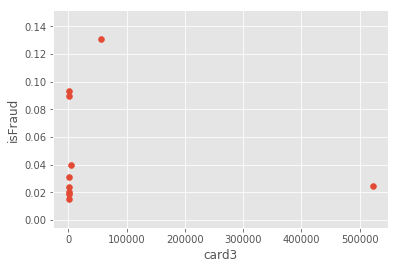

In [69]:
plt.scatter(x =column_name,y='isFraud' ,data=temp)
plt.xlabel(column_name)
plt.ylabel('isFraud')
plt.show()

In [70]:
for i in fraudulent_card:
    train[column_name + '_' + str(i)] = train[column_name].progress_apply(lambda x: 1 if i == x else 0)
    test[column_name + '_' + str(i)] = test[column_name].progress_apply(lambda x: 1 if i == x else 0)    

100%|██████████| 506691/506691 [00:00<00:00, 908331.56it/s] 


In [71]:
le = LabelEncoder()
le.fit(list(train[column_name]) + list(test[column_name]))
train[column_name] = le.transform(train[column_name])
test[column_name] = le.transform(test[column_name])

# Card 4

In [72]:
column_name = 'card4'
train[column_name].head()

0      discover
1    mastercard
2          visa
3    mastercard
4    mastercard
Name: card4, dtype: object

In [73]:
train[column_name].isnull().sum(),test[column_name].isnull().sum()

(1577, 3086)

In [74]:
train[column_name].nunique(),test[column_name].nunique()

(4, 4)

In [75]:
train[column_name].unique()

array(['discover', 'mastercard', 'visa', 'american express', nan],
      dtype=object)

In [76]:
train[column_name].fillna('no_card',inplace=True)
test[column_name].fillna('no_card',inplace=True)

In [77]:
train.groupby(column_name)['isFraud'].mean()

card4
american express    0.028698
discover            0.077282
mastercard          0.034331
no_card             0.025999
visa                0.034756
Name: isFraud, dtype: float64

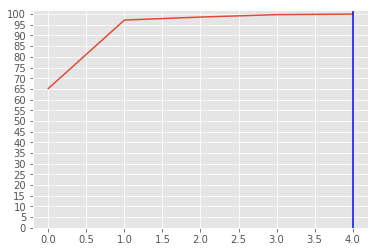

In [78]:
pd.Series(train[column_name].value_counts(normalize=True,dropna=False)*100).cumsum().reset_index(drop=True).plot(kind='line')
plt.axvline(4,color='blue')
plt.yticks(range(0,101,5))
plt.show()

In [79]:
temp = pd.concat([train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False),train[column_name].value_counts()],axis=1)
temp = temp.sort_values(by = 'isFraud',ascending= False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [80]:
temp['fraud_count'] = temp['isFraud'] * temp[column_name]

In [81]:
temp.head(10)

,isFraud,card4,fraud_count
discover,0.077282,6651,514.0
visa,0.034756,384767,13373.0
mastercard,0.034331,189217,6496.0
american express,0.028698,8328,239.0
no_card,0.025999,1577,41.0


In [82]:
mask1 = (temp['isFraud'] > 0.07) & (temp[column_name] > 30)

In [83]:
fraudulent_card = [x for x in list(temp[mask1].index)]

In [84]:
for i in fraudulent_card:
    train[column_name + '_' + str(i)] = train[column_name].progress_apply(lambda x: 1 if i == x else 0)
    test[column_name + '_' + str(i)] = test[column_name].progress_apply(lambda x: 1 if i == x else 0)    

100%|██████████| 506691/506691 [00:00<00:00, 940458.89it/s] 


In [85]:
le = LabelEncoder()
le.fit(list(train[column_name]) + list(test[column_name]))
train[column_name] = le.transform(train[column_name])
test[column_name] = le.transform(test[column_name])

# card5

In [86]:
column_name = 'card5'
train[column_name].head()

0    142.0
1    102.0
2    166.0
3    117.0
4    102.0
Name: card5, dtype: float64

In [87]:
train[train[column_name].isnull()]['isFraud'].value_counts(normalize=True)

0    0.950693
1    0.049307
Name: isFraud, dtype: float64

In [88]:
train[column_name + '_' + 'nan'] = train[column_name].progress_apply(lambda x: 1 if np.isnan(x) else 0)
test[column_name + '_' + 'nan'] = test[column_name].progress_apply(lambda x: 1 if np.isnan(x) else 0)

100%|██████████| 506691/506691 [00:00<00:00, 508193.78it/s]


In [89]:
train[column_name].isnull().sum(),test[column_name].isnull().sum()

(4259, 4547)

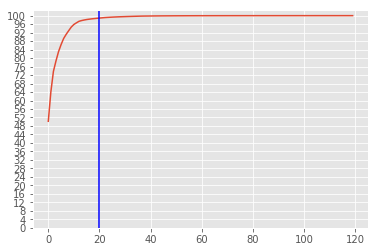

In [90]:
pd.Series(train[column_name].value_counts(normalize=True,dropna=False)*100).cumsum().reset_index(drop=True).plot(kind='line')
plt.axvline(20,color='blue')
plt.yticks(range(0,101,4))
plt.show()

In [91]:
train[column_name].fillna(999999,inplace=True)
test[column_name].fillna(999999,inplace=True)

In [92]:
temp = list(pd.concat([train[column_name],test[column_name]],axis= 0).value_counts().head(20).index)
print(len(temp))
temp = [x for x in temp if x in train[column_name].unique()]
temp = [x for x in temp if x in test[column_name].unique()]
print(len(temp))

20
19


In [93]:
train[column_name] = train[column_name].progress_apply(less_category)
test[column_name] = test[column_name].progress_apply(less_category)

100%|██████████| 506691/506691 [00:00<00:00, 966328.84it/s] 


In [94]:
train[column_name + '_999999'] = train[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)
test[column_name + '_999999'] = test[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)

100%|██████████| 506691/506691 [00:00<00:00, 914945.85it/s] 


In [95]:
train[column_name].nunique(),test[column_name].nunique()

(19, 19)

In [96]:
temp = pd.concat([train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False),train[column_name].value_counts()],axis=1)
temp = temp.sort_values(by = 'isFraud',ascending= False)

In [97]:
temp['fraud_count'] = temp['isFraud'] * temp[column_name]

In [98]:
temp

,isFraud,card5,fraud_count
137.0,0.147184,11720,1725.0
223.0,0.088675,936,83.0
138.0,0.085221,19737,1682.0
162.0,0.066534,4524,301.0
102.0,0.062945,29105,1832.0
219.0,0.057537,9924,571.0
197.0,0.055448,1551,86.0
195.0,0.040189,16945,681.0
224.0,0.038669,81513,3152.0
999999.0,0.031915,18800,600.0


In [99]:
mask1 = ((temp['isFraud'] > 0.10) & (temp[column_name] > 30)) | ((temp['isFraud'] < 0.02) & (temp[column_name] > 30))

In [100]:
temp.head()

,isFraud,card5,fraud_count
137.0,0.147184,11720,1725.0
223.0,0.088675,936,83.0
138.0,0.085221,19737,1682.0
162.0,0.066534,4524,301.0
102.0,0.062945,29105,1832.0


In [101]:
fraudulent_card = [x for x in list(temp[mask1].index)]

In [102]:
fraudulent_card

[137.0, 118.0, 100.0, 150.0, 229.0, 117.0, 166.0, 126.0]

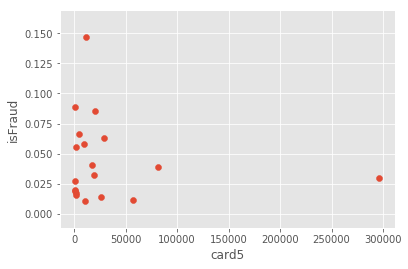

In [103]:
plt.scatter(x =column_name,y='isFraud' ,data=temp)
plt.xlabel(column_name)
plt.ylabel('isFraud')
plt.show()

In [104]:
for i in tqdm(fraudulent_card):
    train[column_name + '_' + str(i)] = train[column_name].progress_apply(lambda x: 1 if i == x else 0)
    test[column_name + '_' + str(i)] = test[column_name].progress_apply(lambda x: 1 if i == x else 0)    

100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


In [105]:
le = LabelEncoder()
le.fit(list(train[column_name]) + list(test[column_name]))
train[column_name] = le.transform(train[column_name])
test[column_name] = le.transform(test[column_name])

# card6

In [106]:
column_name = 'card6'

In [107]:
train[column_name].value_counts(normalize=True)

debit              0.746963
credit             0.252961
debit or credit    0.000051
charge card        0.000025
Name: card6, dtype: float64

In [108]:
train[column_name] = train[column_name].progress_apply(lambda x : 'debit' if x !='credit' else 'credit')
test[column_name] = test[column_name].progress_apply(lambda x : 'debit' if x !='credit' else 'credit')

100%|██████████| 506691/506691 [00:00<00:00, 1093568.05it/s]


In [109]:
train[column_name].value_counts(normalize=True)

debit     0.747712
credit    0.252288
Name: card6, dtype: float64

In [110]:
train['is_debit'] = train[column_name].progress_apply(lambda x: 1 if x =='debit' else 0)
test['is_debit'] = test[column_name].progress_apply(lambda x: 1 if x =='debit' else 0)

100%|██████████| 506691/506691 [00:00<00:00, 956040.59it/s] 


# ProductCD

In [111]:
column_name = 'ProductCD'
train[column_name].head()

0    W
1    W
2    W
3    W
4    H
Name: ProductCD, dtype: object

In [112]:
train[column_name].isnull().sum(),test[column_name].isnull().sum()

(0, 0)

In [113]:
train[column_name].nunique(),test[column_name].nunique()

(5, 5)

In [114]:
train[column_name].unique()

array(['W', 'H', 'C', 'S', 'R'], dtype=object)

In [115]:
train[column_name].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [116]:
train.groupby(column_name)['isFraud'].mean()

ProductCD
C    0.116873
H    0.047662
R    0.037826
S    0.058996
W    0.020399
Name: isFraud, dtype: float64

In [117]:
train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False)

ProductCD
C    0.116873
S    0.058996
H    0.047662
R    0.037826
W    0.020399
Name: isFraud, dtype: float64

In [118]:
train[column_name].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [119]:
temp = pd.concat([train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False),train[column_name].value_counts()],axis=1)
temp = temp.sort_values(by = 'isFraud',ascending= False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [120]:
temp['fraud_count'] = temp['isFraud'] * temp[column_name]

In [121]:
temp.head(10)

,isFraud,ProductCD,fraud_count
C,0.116873,68519,8008.0
S,0.058996,11628,686.0
H,0.047662,33024,1574.0
R,0.037826,37699,1426.0
W,0.020399,439670,8969.0


In [122]:
mask1 = ((temp['isFraud'] > 0.10) & (temp[column_name] > 30)) | ((temp['isFraud'] < 0.0250) & (temp[column_name] > 30))

In [123]:
fraudulent_card = [x for x in list(temp[mask1].index)]

In [124]:
print(fraudulent_card)

['C', 'W']


In [125]:
for i in fraudulent_card:
    train[column_name + '_' + str(i)] = train[column_name].progress_apply(lambda x: 1 if i == x else 0)
    test[column_name + '_' + str(i)] = test[column_name].progress_apply(lambda x: 1 if i == x else 0)    

100%|██████████| 506691/506691 [00:00<00:00, 938730.37it/s] 


In [126]:
le = LabelEncoder()
le.fit(list(train[column_name]) + list(test[column_name]))
train[column_name] = le.transform(train[column_name])
test[column_name] = le.transform(test[column_name])

# addr1

In [127]:
column_name = 'addr1'
train[column_name].head()

0    315.0
1    325.0
2    330.0
3    476.0
4    420.0
Name: addr1, dtype: float64

In [128]:
train[column_name].isnull().sum(),test[column_name].isnull().sum()

(65706, 65609)

In [129]:
train[column_name].nunique(),test[column_name].nunique()

(332, 292)

In [130]:
train[column_name].unique()[:5]

array([315., 325., 330., 476., 420.])

In [131]:
train[column_name].fillna(888888,inplace=True)
test[column_name].fillna(888888,inplace=True)

In [132]:
train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False).head(10)

addr1
305.0    0.666667
483.0    0.565217
471.0    0.500000
501.0    0.500000
466.0    0.500000
391.0    0.457143
431.0    0.342105
260.0    0.333333
432.0    0.289474
216.0    0.240741
Name: isFraud, dtype: float64

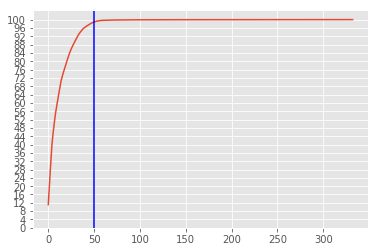

In [133]:
pd.Series(train[column_name].value_counts(normalize=True,dropna=False)*100).cumsum().reset_index(drop=True).plot(kind='line')
plt.axvline(50,color='blue')
plt.yticks(range(0,101,4))
plt.show()

In [134]:
temp = list(pd.concat([train[column_name],test[column_name]],axis= 0).value_counts().head(50).index)
print(len(temp))
temp = [x for x in temp if x in train[column_name].unique()]
temp = [x for x in temp if x in test[column_name].unique()]
print(len(temp))

50
50


In [135]:
train[column_name] = train[column_name].progress_apply(less_category)
test[column_name] = test[column_name].progress_apply(less_category)

100%|██████████| 506691/506691 [00:00<00:00, 901928.95it/s]


In [136]:
train[column_name + '_999999'] = train[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)
test[column_name + '_999999'] = test[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)

100%|██████████| 506691/506691 [00:00<00:00, 912265.35it/s] 


In [137]:
train[column_name + '_nan'] = train[column_name].progress_apply(lambda x: 1 if x == 888888 else 0)
test[column_name + '_nan'] = test[column_name].progress_apply(lambda x: 1 if x == 888888 else 0)

100%|██████████| 506691/506691 [00:00<00:00, 910571.32it/s] 


In [138]:
temp = pd.concat([train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False),train[column_name].value_counts()],axis=1)
temp = temp.sort_values(by = 'isFraud',ascending= False)

In [139]:
temp['fraud_count'] = temp['isFraud'] * temp[column_name]

In [140]:
mask1 = ((temp['isFraud'] > 0.10) & (temp[column_name] > 50)) | ((temp['isFraud'] < 0.0175) & (temp[column_name] > 50))

In [141]:
fraudulent_card = [x for x in list(temp[mask1].index)]

In [142]:
print(fraudulent_card)

[888888.0, 191.0, 184.0, 436.0, 143.0, 205.0, 194.0, 494.0, 444.0]


In [143]:
for i in fraudulent_card:
    train[column_name + '_' + str(i)] = train[column_name].progress_apply(lambda x: 1 if i == x else 0)
    test[column_name + '_' + str(i)] = test[column_name].progress_apply(lambda x: 1 if i == x else 0)    

100%|██████████| 506691/506691 [00:00<00:00, 942472.91it/s] 


In [144]:
le = LabelEncoder()
le.fit(list(train[column_name]) + list(test[column_name]))
train[column_name] = le.transform(train[column_name])
test[column_name] = le.transform(test[column_name])

# addr2

In [145]:
column_name = 'addr2'
train[column_name].head()

0    87.0
1    87.0
2    87.0
3    87.0
4    87.0
Name: addr2, dtype: float64

In [146]:
train[column_name].isnull().sum(),test[column_name].isnull().sum()

(65706, 65609)

In [147]:
train[column_name].nunique(),test[column_name].nunique()

(74, 72)

In [148]:
train[column_name].unique()[:5]

array([87., nan, 96., 35., 60.])

In [149]:
train[column_name].fillna(888888,inplace=True)
test[column_name].fillna(888888,inplace=True)

In [150]:
train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False).head(10)

addr2
10.0    1.000000
82.0    1.000000
46.0    1.000000
51.0    1.000000
92.0    1.000000
75.0    1.000000
38.0    0.666667
65.0    0.536585
36.0    0.500000
54.0    0.333333
Name: isFraud, dtype: float64

In [151]:
train[column_name].value_counts(normalize=True).head(10)*100

87.0        88.136451
888888.0    11.126427
60.0         0.522234
96.0         0.108037
32.0         0.015410
65.0         0.013886
16.0         0.009314
31.0         0.007959
19.0         0.005588
26.0         0.004233
Name: addr2, dtype: float64

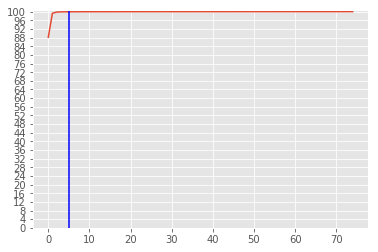

In [152]:
pd.Series(train[column_name].value_counts(normalize=True,dropna=False)*100).cumsum().reset_index(drop=True).plot(kind='line')
plt.axvline(5,color='blue')
plt.yticks(range(0,101,4))
plt.show()

In [153]:
temp = list(pd.concat([train[column_name],test[column_name]],axis= 0).value_counts().head(5).index)
print(len(temp))
temp = [x for x in temp if x in train[column_name].unique()]
temp = [x for x in temp if x in test[column_name].unique()]
print(len(temp))

5
5


In [154]:
train[column_name] = train[column_name].progress_apply(less_category)
test[column_name] = test[column_name].progress_apply(less_category)

100%|██████████| 506691/506691 [00:00<00:00, 1023724.92it/s]


In [155]:
train[column_name + '_999999'] = train[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)
test[column_name + '_999999'] = test[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)

100%|██████████| 506691/506691 [00:00<00:00, 920621.11it/s] 


In [156]:
train[column_name + '_nan'] = train[column_name].progress_apply(lambda x: 1 if x == 888888 else 0)
test[column_name + '_nan'] = test[column_name].progress_apply(lambda x: 1 if x == 888888 else 0)

100%|██████████| 506691/506691 [00:00<00:00, 910389.94it/s] 


In [157]:
temp = pd.concat([train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False),train[column_name].value_counts()],axis=1)
temp = temp.sort_values(by = 'isFraud',ascending= False)

In [158]:
temp['fraud_count'] = temp['isFraud'] * temp[column_name]

In [159]:
temp

,isFraud,addr2,fraud_count
96.0,0.139498,638,89.0
999999.0,0.131481,540,71.0
888888.0,0.117813,65706,7741.0
60.0,0.090467,3084,279.0
32.0,0.065934,91,6.0
87.0,0.023972,520481,12477.0


In [160]:
mask1 = ((temp['isFraud'] > 0.10) & (temp[column_name] > 50)) | ((temp['isFraud'] < 0.0175) & (temp[column_name] > 50))

In [161]:
fraudulent_card = [x for x in list(temp[mask1].index)]
fraudulent_card.remove(888888.0)

In [162]:
print(fraudulent_card)

[96.0, 999999.0]


In [163]:
for i in fraudulent_card:
    train[column_name + '_' + str(i)] = train[column_name].progress_apply(lambda x: 1 if i == x else 0)
    test[column_name + '_' + str(i)] = test[column_name].progress_apply(lambda x: 1 if i == x else 0)    

100%|██████████| 506691/506691 [00:00<00:00, 934091.53it/s] 


In [164]:
le = LabelEncoder()
le.fit(list(train[column_name]) + list(test[column_name]))
train[column_name] = le.transform(train[column_name])
test[column_name] = le.transform(test[column_name])

In [165]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DT,month,weekofyear,dayofyear,hour,dayofweek,day,card1_999999,card1_fraudulent,card2_999999,card2_fraudulent,card3_999999,card3_185.0,card4_discover,card5_nan,card5_999999,card5_137.0,card5_118.0,card5_100.0,card5_150.0,card5_229.0,card5_117.0,card5_166.0,card5_126.0,is_debit,ProductCD_C,ProductCD_W,addr1_999999,addr1_nan,addr1_888888.0,addr1_191.0,addr1_184.0,addr1_436.0,addr1_143.0,addr1_205.0,addr1_194.0,addr1_494.0,addr1_444.0,addr2_999999,addr2_nan,addr2_96.0,addr2_999999.0
0,2987000,0,86400,68.5,4,2386,297,7,1,18,credit,27,2,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0

# TransactionAmt

In [166]:
train['TransactionAmt'].describe()

count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
25%          43.321000
50%          68.769000
75%         125.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

In [167]:
stats.ks_2samp(train['TransactionAmt'], test['TransactionAmt'])

Ks_2sampResult(statistic=0.017615443575332068, pvalue=5.830897004871469e-74)

In [168]:
stats.ks_2samp(np.log(train['TransactionAmt']), np.log(train['TransactionAmt']))

Ks_2sampResult(statistic=0.0, pvalue=1.0)

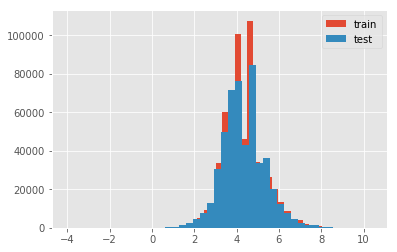

In [169]:
plt.hist(np.log(train['TransactionAmt']),bins=40,label='train')
plt.hist(np.log(test['TransactionAmt']),bins=40,label='test')
plt.legend()
plt.show()

In [170]:
train.groupby('isFraud')['TransactionAmt'].mean()

isFraud
0    134.511665
1    149.244779
Name: TransactionAmt, dtype: float64

In [171]:
# New feature - decimal part of the transaction amount
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

In [172]:
train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check']  = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

# dist1

In [173]:
column_name = 'dist1'
train[column_name].head()

0     19.0
1      NaN
2    287.0
3      NaN
4      NaN
Name: dist1, dtype: float64

In [174]:
train[column_name].isnull().sum(),test[column_name].isnull().sum()

(352271, 291217)

In [175]:
train[column_name].nunique(),test[column_name].nunique()

(2651, 1988)

In [176]:
train[column_name].unique()[:5]

array([ 19.,  nan, 287.,  36.,   0.])

In [177]:
train[column_name].fillna(888888,inplace=True)
test[column_name].fillna(888888,inplace=True)

In [178]:
train[column_name].value_counts(normalize=True).head(10)*100

888888.0    59.652352
0.0          3.356928
1.0          3.103939
2.0          2.883463
4.0          2.212721
3.0          2.168862
5.0          2.032716
6.0          1.666780
7.0          1.581603
8.0          1.309141
Name: dist1, dtype: float64

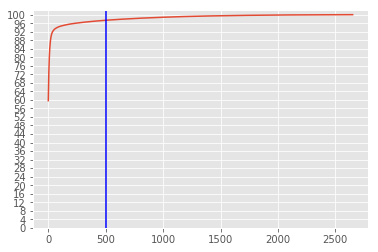

In [179]:
pd.Series(train[column_name].value_counts(normalize=True,dropna=False)*100).cumsum().reset_index(drop=True).plot(kind='line')
plt.axvline(500,color='blue')
plt.yticks(range(0,101,4))
plt.show()

In [180]:
temp = list(pd.concat([train[column_name],test[column_name]],axis= 0).value_counts().head(500).index)
print(len(temp))
temp = [x for x in temp if x in train[column_name].unique()]
temp = [x for x in temp if x in test[column_name].unique()]
print(len(temp))

500
498


In [181]:
train[column_name] = train[column_name].progress_apply(less_category)
test[column_name] = test[column_name].progress_apply(less_category)

100%|██████████| 506691/506691 [00:00<00:00, 843846.70it/s]


In [182]:
train[column_name + '_999999'] = train[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)
test[column_name + '_999999'] = test[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)

100%|██████████| 506691/506691 [00:00<00:00, 930833.24it/s] 


In [183]:
train[column_name + '_nan'] = train[column_name].progress_apply(lambda x: 1 if x == 888888 else 0)
test[column_name + '_nan'] = test[column_name].progress_apply(lambda x: 1 if x == 888888 else 0)

100%|██████████| 506691/506691 [00:00<00:00, 916176.87it/s] 


In [184]:
temp = pd.concat([train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False),train[column_name].value_counts()],axis=1)
temp = temp.sort_values(by = 'isFraud',ascending= False)

In [185]:
temp['fraud_count'] = temp['isFraud'] * temp[column_name]

In [186]:
temp.sample(10)

,isFraud,dist1,fraud_count
181.0,0.000000,86,0.0
265.0,0.000000,28,0.0
268.0,0.000000,35,0.0
820.0,0.064516,31,2.0
561.0,0.000000,43,0.0
991.0,0.010381,289,3.0
777.0,0.000000,8,0.0
94.0,0.009434,106,1.0
1105.0,0.000000,38,0.0
1001.0,0.023256,43,1.0


In [187]:
mask1 = ((temp['isFraud'] > 0.10) & (temp[column_name] > 100)) | ((temp['isFraud'] < 0.0100) & (temp[column_name] > 250))

In [188]:
fraudulent_card = [x for x in list(temp[mask1].index)]
try:
    fraudulent_card.remove(888888.0)
except:
    print("{} not in fraudulent_card".format(888888.0))

888888.0 not in fraudulent_card


In [189]:
print(fraudulent_card)

[91.0, 130.0, 116.0, 108.0, 86.0, 95.0, 114.0, 33.0, 12.0, 27.0, 50.0, 55.0, 54.0, 42.0, 47.0, 35.0, 43.0, 49.0]


In [190]:
for i in fraudulent_card:
    train[column_name + '_' + str(i)] = train[column_name].progress_apply(lambda x: 1 if i == x else 0)
    test[column_name + '_' + str(i)] = test[column_name].progress_apply(lambda x: 1 if i == x else 0)    

100%|██████████| 506691/506691 [00:00<00:00, 950842.24it/s] 


In [191]:
le = LabelEncoder()
le.fit(list(train[column_name]) + list(test[column_name]))
train[column_name] = le.transform(train[column_name])
test[column_name] = le.transform(test[column_name])

In [192]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DT,month,weekofyear,dayofyear,hour,dayofweek,day,card1_999999,card1_fraudulent,card2_999999,card2_fraudulent,card3_999999,card3_185.0,card4_discover,card5_nan,card5_999999,card5_137.0,card5_118.0,card5_100.0,card5_150.0,card5_229.0,card5_117.0,card5_166.0,card5_126.0,is_debit,ProductCD_C,ProductCD_W,addr1_999999,addr1_nan,addr1_888888.0,addr1_191.0,addr1_184.0,addr1_436.0,addr1_143.0,addr1_205.0,addr1_194.0,addr1_494.0,addr1_444.0,addr2_999999,addr2_nan,addr2_96.0,addr2_999999.0,TransactionAmt_decimal,TransactionAmt_check,dist1_999999,dist1_nan,dist1_91.0,dist1_130.0,dist1_116.0,dist1_108.0,dist1_86.0,dist1_95.0,dist1_114.0,dist1_33.0,dist1_12.0,dist1_27.0,dist1_50.0,dist1_55.0,dist1_54.0,dist1_42.0,dist1_47.0,dist1_35.0,dist1_43.0,dist1_49.0
0,2987000,0,86400,68.5,4,2386,297,7,1,18,credit,27,2,19,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# dist2

In [193]:
column_name = 'dist2'
train[column_name].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: dist2, dtype: float64

In [194]:
train[column_name].isnull().sum(),test[column_name].isnull().sum()

(552913, 470255)

In [195]:
train[column_name].isnull().sum()/len(train),test[column_name].isnull().sum()/len(test)

(0.9362837403054831, 0.9280902956634319)

In [196]:
train[column_name].nunique(),test[column_name].nunique()

(1751, 1814)

In [197]:
train[column_name].unique()[:5]

array([ nan,  30.,  98., 149.,  84.])

In [198]:
train[column_name].fillna(888888,inplace=True)
test[column_name].fillna(888888,inplace=True)

In [199]:
train[column_name].value_counts(normalize=True).head(10)*100

888888.0    93.628374
7.0          0.963017
0.0          0.595895
1.0          0.232668
9.0          0.125648
4.0          0.111593
2.0          0.094151
3.0          0.082975
68.0         0.082128
6.0          0.069767
Name: dist2, dtype: float64

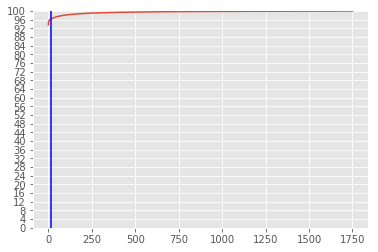

In [200]:
pd.Series(train[column_name].value_counts(normalize=True,dropna=False)*100).cumsum().reset_index(drop=True).plot(kind='line')
plt.axvline(15,color='blue')
plt.yticks(range(0,101,4))
plt.show()

In [201]:
temp = list(pd.concat([train[column_name],test[column_name]],axis= 0).value_counts().head(15).index)
print(len(temp))
temp = [x for x in temp if x in train[column_name].unique()]
temp = [x for x in temp if x in test[column_name].unique()]
print(len(temp))

15
15


In [202]:
train[column_name] = train[column_name].progress_apply(less_category)
test[column_name] = test[column_name].progress_apply(less_category)

100%|██████████| 506691/506691 [00:00<00:00, 1007500.77it/s]


In [203]:
train[column_name + '_999999'] = train[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)
test[column_name + '_999999'] = test[column_name].progress_apply(lambda x: 1 if x == 999999 else 0)

100%|██████████| 506691/506691 [00:00<00:00, 922991.70it/s] 


In [204]:
train[column_name + '_nan'] = train[column_name].progress_apply(lambda x: 1 if x == 888888 else 0)
test[column_name + '_nan'] = test[column_name].progress_apply(lambda x: 1 if x == 888888 else 0)

100%|██████████| 506691/506691 [00:00<00:00, 920049.58it/s] 


In [205]:
temp = pd.concat([train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False),train[column_name].value_counts()],axis=1)
temp = temp.sort_values(by = 'isFraud',ascending= False)

In [206]:
temp['fraud_count'] = temp['isFraud'] * temp[column_name]

In [207]:
temp

,isFraud,dist2,fraud_count
0.0,0.153453,3519,540.0
9.0,0.148248,742,110.0
1.0,0.139738,1374,192.0
11.0,0.102804,214,22.0
10.0,0.101124,356,36.0
68.0,0.096907,485,47.0
999999.0,0.094943,22245,2112.0
19.0,0.091703,229,21.0
7.0,0.087216,5687,496.0
13.0,0.078086,397,31.0


In [208]:
mask1 = ((temp['isFraud'] > 0.08) & (temp[column_name] > 300)) | ((temp['isFraud'] < 0.0100) & (temp[column_name] > 250))

In [209]:
fraudulent_card = [x for x in list(temp[mask1].index)]
try:
    fraudulent_card.remove(888888.0)
except:
    print("{} not in fraudulent_card".format(888888.0))

888888.0 not in fraudulent_card


In [210]:
print(fraudulent_card)

[0.0, 9.0, 1.0, 10.0, 68.0, 999999.0, 7.0]


In [211]:
for i in fraudulent_card:
    train[column_name + '_' + str(i)] = train[column_name].progress_apply(lambda x: 1 if i == x else 0)
    test[column_name + '_' + str(i)] = test[column_name].progress_apply(lambda x: 1 if i == x else 0)    

100%|██████████| 506691/506691 [00:00<00:00, 920564.48it/s] 


In [212]:
le = LabelEncoder()
le.fit(list(train[column_name]) + list(test[column_name]))
train[column_name] = le.transform(train[column_name])
test[column_name] = le.transform(test[column_name])

In [213]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,...,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DT,month,weekofyear,dayofyear,hour,dayofweek,day,card1_999999,card1_fraudulent,card2_999999,card2_fraudulent,card3_999999,card3_185.0,card4_discover,card5_nan,card5_999999,card5_137.0,card5_118.0,card5_100.0,card5_150.0,card5_229.0,card5_117.0,card5_166.0,card5_126.0,is_debit,ProductCD_C,ProductCD_W,addr1_999999,addr1_nan,addr1_888888.0,addr1_191.0,addr1_184.0,addr1_436.0,addr1_143.0,addr1_205.0,addr1_194.0,addr1_494.0,addr1_444.0,addr2_999999,addr2_nan,addr2_96.0,addr2_999999.0,TransactionAmt_decimal,TransactionAmt_check,dist1_999999,dist1_nan,dist1_91.0,dist1_130.0,dist1_116.0,dist1_108.0,dist1_86.0,dist1_95.0,dist1_114.0,dist1_33.0,dist1_12.0,dist1_27.0,dist1_50.0,dist1_55.0,dist1_54.0,dist1_42.0,dist1_47.0,dist1_35.0,dist1_43.0,dist1_49.0,dist2_999999,dist2_nan,dist2_0.0,dist2_9.0,dist2_1.0,dist2_10.0,dist2_68.0,dist2_999999.0,dist2_7.0
0,2987000,0,86400,68.5,4,2386,297,7,1,18,credit,27,2,19,14,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# P_emaildomain

In [214]:
column_name = 'P_emaildomain'

In [215]:
train[column_name].head()

0            NaN
1      gmail.com
2    outlook.com
3      yahoo.com
4      gmail.com
Name: P_emaildomain, dtype: object

In [216]:
train[column_name].isnull().sum(),test[column_name].isnull().sum()

(94456, 69192)

In [217]:
train[column_name].isnull().sum()/len(train),test[column_name].isnull().sum()/len(test)

(0.1599485216920107, 0.13655659958436206)

In [218]:
[x for x in test[column_name].unique() if x not in train[column_name].unique()]

[nan, 'scranton.edu']

In [219]:
test[column_name] = test[column_name].progress_apply(lambda x: np.nan if x=='scranton.edu' else x)

100%|██████████| 506691/506691 [00:00<00:00, 1012495.59it/s]


In [220]:
train[column_name].nunique(),test[column_name].nunique()

(59, 59)

In [221]:
train[column_name].unique()[:5]

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com'],
      dtype=object)

In [222]:
def divide_it_prefix(x):
    try:
        return x.split('.')[0]
    except:
        return str(x)
def divide_it_suffix(x):
    try:
        return x.split('.')[1]
    except:
        return x

In [223]:
train[column_name + '_prefix'] = train[column_name].progress_apply(lambda x: divide_it_prefix(x))
train[column_name + '_suffix'] = train[column_name].progress_apply(lambda x: divide_it_suffix(x))

100%|██████████| 590540/590540 [00:00<00:00, 811110.48it/s]


In [224]:
test[column_name + '_prefix'] = test[column_name].progress_apply(lambda x: divide_it_prefix(x))
test[column_name + '_suffix'] = test[column_name].progress_apply(lambda x: divide_it_suffix(x))

100%|██████████| 506691/506691 [00:00<00:00, 770639.65it/s]


In [225]:
train[column_name].fillna('888888',inplace=True)
test[column_name].fillna('888888',inplace=True)

In [226]:
train[column_name].value_counts(normalize=True).head(20)*100

gmail.com        38.668845
yahoo.com        17.091814
888888           15.994852
hotmail.com       7.662478
anonymous.com     6.265113
aol.com           4.790361
comcast.net       1.335727
icloud.com        1.061232
outlook.com       0.862939
msn.com           0.692925
att.net           0.682934
live.com          0.514952
sbcglobal.net     0.502930
verizon.net       0.458055
ymail.com         0.405730
bellsouth.net     0.323263
yahoo.com.mx      0.261286
me.com            0.257730
cox.net           0.235886
optonline.net     0.171199
Name: P_emaildomain, dtype: float64

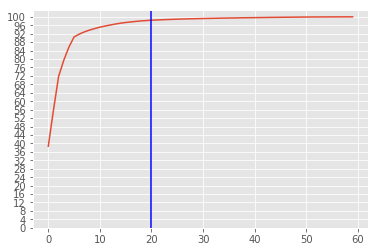

In [227]:
pd.Series(train[column_name].value_counts(normalize=True,dropna=False)*100).cumsum().reset_index(drop=True).plot(kind='line')
plt.axvline(20,color='blue')
plt.yticks(range(0,101,4))
plt.show()

In [228]:
temp = list(pd.concat([train[column_name],test[column_name]],axis= 0).value_counts().head(20).index)
print(len(temp))
temp = [x for x in temp if x in train[column_name].unique()]
temp = [x for x in temp if x in test[column_name].unique()]
print(len(temp))

20
20


In [229]:
column_name_temp = column_name +'_lesscategory'

In [230]:
train[column_name_temp] = train[column_name].progress_apply(less_category_str)
test[column_name_temp] = test[column_name].progress_apply(less_category_str)

100%|██████████| 506691/506691 [00:00<00:00, 1032661.88it/s]


In [231]:
train[column_name + '_999999'] = train[column_name_temp].progress_apply(lambda x: 1 if x == '999999' else 0)
test[column_name + '_999999'] = test[column_name_temp].progress_apply(lambda x: 1 if x == '999999' else 0)

100%|██████████| 506691/506691 [00:00<00:00, 959501.46it/s] 


In [232]:
train[column_name + '_nan'] = train[column_name].progress_apply(lambda x: 1 if x == '888888' else 0)
test[column_name + '_nan'] = test[column_name].progress_apply(lambda x: 1 if x == '888888' else 0)

100%|██████████| 506691/506691 [00:00<00:00, 931617.91it/s] 


In [233]:
temp = pd.concat([train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False),train[column_name].value_counts()],axis=1)
temp = temp.sort_values(by = 'isFraud',ascending= False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [234]:
temp['fraud_count'] = temp['isFraud'] * temp[column_name]

In [235]:
temp.head()

,isFraud,P_emaildomain,fraud_count
protonmail.com,0.407895,76,31.0
mail.com,0.189624,559,106.0
outlook.es,0.130137,438,57.0
aim.com,0.126984,315,40.0
outlook.com,0.094584,5096,482.0


In [236]:
mask1 = ((temp['isFraud'] > 0.08) & (temp[column_name] > 300)) | ((temp['isFraud'] < 0.0100) & (temp[column_name] > 250))

In [237]:
fraudulent_card = [x for x in list(temp[mask1].index)]
try:
    fraudulent_card.remove(888888.0)
except:
    print("{} not in fraudulent_card".format(888888.0))

888888.0 not in fraudulent_card


In [238]:
print(fraudulent_card)

['mail.com', 'outlook.es', 'aim.com', 'outlook.com', 'roadrunner.com', 'verizon.net', 'att.net', 'sbcglobal.net', 'rocketmail.com', 'windstream.net', 'hotmail.fr']


In [239]:
for i in fraudulent_card:
    train[column_name + '_' + str(i)] = train[column_name].progress_apply(lambda x: 1 if i == x else 0)
    test[column_name + '_' + str(i)] = test[column_name].progress_apply(lambda x: 1 if i == x else 0)    

100%|██████████| 506691/506691 [00:00<00:00, 943319.20it/s] 


In [240]:
#protonmail.com
train[column_name + '_protonmail'] = train[column_name].progress_apply(lambda x: 1 if x =='protonmail.com' else 0)
test[column_name + '_protonmail'] = test[column_name].progress_apply(lambda x: 1 if x =='protonmail.com' else 0)

100%|██████████| 506691/506691 [00:00<00:00, 959389.27it/s] 


In [241]:
#column_name
train[column_name] = train[column_name].progress_apply(str)
test[column_name] = test[column_name].progress_apply(str)
#column_name_temp
train[column_name_temp] = train[column_name_temp].progress_apply(str)
test[column_name_temp] = test[column_name_temp].progress_apply(str)

100%|██████████| 506691/506691 [00:00<00:00, 1169081.56it/s]


In [242]:
le = LabelEncoder()
le.fit(list(train[column_name]) + list(test[column_name]))
train[column_name] = le.transform(train[column_name])
test[column_name] = le.transform(test[column_name])

In [243]:
le = LabelEncoder()
le.fit(list(train[column_name_temp]) + list(test[column_name_temp]))
train[column_name_temp] = le.transform(train[column_name_temp])
test[column_name_temp] = le.transform(test[column_name_temp])

In [244]:
train[column_name + '_prefix'] = train[column_name + '_prefix'].progress_apply(str)
train[column_name + '_suffix'] = train[column_name + '_suffix'].progress_apply(str)
test[column_name + '_prefix'] = test[column_name + '_prefix'].progress_apply(str)
test[column_name + '_suffix'] = test[column_name + '_suffix'].progress_apply(str)

100%|██████████| 506691/506691 [00:00<00:00, 1140224.86it/s]


In [245]:
#prefix
le = LabelEncoder()
le.fit(list(train[column_name + '_prefix']) + list(test[column_name + '_prefix']))
train[column_name + '_prefix'] = le.transform(train[column_name + '_prefix'])
test[column_name + '_prefix'] = le.transform(test[column_name + '_prefix'])

In [246]:
#suffix
le = LabelEncoder()
le.fit(list(train[column_name + '_suffix']) + list(test[column_name + '_suffix']))
train[column_name + '_suffix'] = le.transform(train[column_name + '_suffix'])
test[column_name + '_suffix'] = le.transform(test[column_name + '_suffix'])

In [247]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,...,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DT,month,weekofyear,dayofyear,hour,dayofweek,day,card1_999999,card1_fraudulent,card2_999999,card2_fraudulent,card3_999999,card3_185.0,card4_discover,card5_nan,card5_999999,card5_137.0,card5_118.0,card5_100.0,card5_150.0,card5_229.0,card5_117.0,card5_166.0,card5_126.0,is_debit,ProductCD_C,ProductCD_W,addr1_999999,addr1_nan,addr1_888888.0,addr1_191.0,addr1_184.0,addr1_436.0,addr1_143.0,addr1_205.0,addr1_194.0,addr1_494.0,addr1_444.0,addr2_999999,addr2_nan,addr2_96.0,addr2_999999.0,TransactionAmt_decimal,TransactionAmt_check,dist1_999999,dist1_nan,dist1_91.0,dist1_130.0,dist1_116.0,dist1_108.0,dist1_86.0,dist1_95.0,dist1_114.0,dist1_33.0,dist1_12.0,dist1_27.0,dist1_50.0,dist1_55.0,dist1_54.0,dist1_42.0,dist1_47.0,dist1_35.0,dist1_43.0,dist1_49.0,dist2_999999,dist2_nan,dist2_0.0,dist2_9.0,dist2_1.0,dist2_10.0,dist2_68.0,dist2_999999.0,dist2_7.0,P_emaildomain_prefix,P_emaildomain_suffix,P_emaildomain_lesscategory,P_emaildomain_999999,P_emaildomain_nan,P_emaildomain_mail.com,P_emaildomain_outlook.es,P_emaildomain_aim.com,P_emaildomain_outlook.com,P_emaildomain_roadrunner.com,P_emaildomain_verizon.net,P_emaildomain_att.net,P_emaildomain_sbcglobal.net,P_emaildomain_rocketmail.com,P_emaildomain_windstream.net,P_emaildomain_hotmail.fr,P_emaildomain_protonmail
0,2987000,0,86400,68.5,4,2386,297,7,1,18,credit,27,2,19,14,0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.

# R_emaildomain

In [248]:
column_name = 'R_emaildomain'

In [249]:
train[column_name].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: R_emaildomain, dtype: object

In [250]:
train[column_name].isnull().sum(),test[column_name].isnull().sum()

(453249, 370821)

In [251]:
train[column_name].isnull().sum()/len(train),test[column_name].isnull().sum()/len(test)

(0.7675161716395164, 0.7318484046489873)

In [252]:
train[column_name].nunique(),test[column_name].nunique()

(60, 60)

In [253]:
[x for x in test[column_name].unique() if x not in train[column_name].unique()]

[nan]

In [254]:
train[column_name].unique()[:5]

array([nan, 'gmail.com', 'hotmail.com', 'outlook.com', 'anonymous.com'],
      dtype=object)

In [255]:
train[column_name + '_prefix'] = train[column_name].progress_apply(lambda x: divide_it_prefix(x))
train[column_name + '_suffix'] = train[column_name].progress_apply(lambda x: divide_it_suffix(x))

100%|██████████| 590540/590540 [00:00<00:00, 711537.17it/s]


In [256]:
test[column_name + '_prefix'] = test[column_name].progress_apply(lambda x: divide_it_prefix(x))
test[column_name + '_suffix'] = test[column_name].progress_apply(lambda x: divide_it_suffix(x))

100%|██████████| 506691/506691 [00:00<00:00, 723733.80it/s]


In [257]:
train[column_name].fillna('888888',inplace=True)
test[column_name].fillna('888888',inplace=True)

In [258]:
train[column_name].value_counts(normalize=True).head(20)*100

888888           76.751617
gmail.com         9.677075
hotmail.com       4.658279
anonymous.com     3.476310
yahoo.com         2.005283
aol.com           0.626715
outlook.com       0.424527
comcast.net       0.306838
yahoo.com.mx      0.255360
icloud.com        0.236732
msn.com           0.144275
live.com          0.129034
live.com.mx       0.127680
verizon.net       0.104989
me.com            0.094151
sbcglobal.net     0.093474
cox.net           0.077725
outlook.es        0.073323
att.net           0.072815
bellsouth.net     0.071460
Name: R_emaildomain, dtype: float64

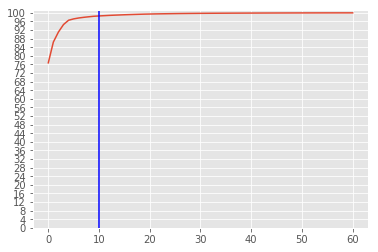

In [259]:
pd.Series(train[column_name].value_counts(normalize=True,dropna=False)*100).cumsum().reset_index(drop=True).plot(kind='line')
plt.axvline(10,color='blue')
plt.yticks(range(0,101,4))
plt.show()

In [260]:
temp = list(pd.concat([train[column_name],test[column_name]],axis= 0).value_counts().head(10).index)
print(len(temp))
temp = [x for x in temp if x in train[column_name].unique()]
temp = [x for x in temp if x in test[column_name].unique()]
print(len(temp))

10
10


In [261]:
column_name_temp = column_name +'_lesscategory'

In [262]:
train[column_name_temp] = train[column_name].progress_apply(less_category_str)
test[column_name_temp] = test[column_name].progress_apply(less_category_str)

100%|██████████| 506691/506691 [00:00<00:00, 1071826.83it/s]


In [263]:
train[column_name + '_999999'] = train[column_name_temp].progress_apply(lambda x: 1 if x == '999999' else 0)
test[column_name + '_999999'] = test[column_name_temp].progress_apply(lambda x: 1 if x == '999999' else 0)

100%|██████████| 506691/506691 [00:00<00:00, 962604.51it/s] 


In [264]:
train[column_name + '_nan'] = train[column_name].progress_apply(lambda x: 1 if x == '888888' else 0)
test[column_name + '_nan'] = test[column_name].progress_apply(lambda x: 1 if x == '888888' else 0)

100%|██████████| 506691/506691 [00:00<00:00, 961682.36it/s] 


In [265]:
temp = pd.concat([train.groupby(column_name)['isFraud'].mean().sort_values(ascending=False),train[column_name].value_counts()],axis=1)
temp = temp.sort_values(by = 'isFraud',ascending= False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [266]:
temp['fraud_count'] = temp['isFraud'] * temp[column_name]

In [267]:
temp.head()

,isFraud,R_emaildomain,fraud_count
protonmail.com,0.951220,41,39.0
mail.com,0.377049,122,46.0
netzero.net,0.222222,9,2.0
outlook.com,0.165138,2507,414.0
outlook.es,0.131640,433,57.0


In [268]:
#protonmail.com
train[column_name + '_protonmail'] = train[column_name].progress_apply(lambda x: 1 if x =='protonmail.com' else 0)
test[column_name + '_protonmail'] = test[column_name].progress_apply(lambda x: 1 if x =='protonmail.com' else 0)

100%|██████████| 506691/506691 [00:00<00:00, 951502.52it/s] 


In [269]:
#column_name
train[column_name] = train[column_name].progress_apply(str)
test[column_name] = test[column_name].progress_apply(str)
#column_name_temp
train[column_name_temp] = train[column_name_temp].progress_apply(str)
test[column_name_temp] = test[column_name_temp].progress_apply(str)

100%|██████████| 506691/506691 [00:00<00:00, 1156558.78it/s]


In [270]:
mask1 = ((temp['isFraud'] > 0.08) & (temp[column_name] > 300)) | ((temp['isFraud'] < 0.0100) & (temp[column_name] > 250))

In [271]:
fraudulent_card = [x for x in list(temp[mask1].index)]
try:
    fraudulent_card.remove(888888.0)
except:
    print("{} not in fraudulent_card".format(888888.0))

888888.0 not in fraudulent_card


In [272]:
print(fraudulent_card)

['outlook.com', 'outlook.es', 'icloud.com', 'gmail.com', 'bellsouth.net', 'sbcglobal.net', 'msn.com', 'verizon.net', 'hotmail.fr', 'att.net']


In [273]:
for i in fraudulent_card:
    train[column_name + '_' + str(i)] = train[column_name].progress_apply(lambda x: 1 if i == x else 0)
    test[column_name + '_' + str(i)] = test[column_name].progress_apply(lambda x: 1 if i == x else 0)    

100%|██████████| 506691/506691 [00:00<00:00, 900249.79it/s] 


In [274]:
#column_name
train[column_name] = train[column_name].progress_apply(str)
test[column_name] = test[column_name].progress_apply(str)
#column_name_temp
train[column_name_temp] = train[column_name_temp].progress_apply(str)
test[column_name_temp] = test[column_name_temp].progress_apply(str)

100%|██████████| 506691/506691 [00:00<00:00, 1167212.46it/s]


In [275]:
le = LabelEncoder()
le.fit(list(train[column_name]) + list(test[column_name]))
train[column_name] = le.transform(train[column_name])
test[column_name] = le.transform(test[column_name])

In [276]:
le = LabelEncoder()
le.fit(list(train[column_name_temp]) + list(test[column_name_temp]))
train[column_name_temp] = le.transform(train[column_name_temp])
test[column_name_temp] = le.transform(test[column_name_temp])

In [277]:
train[column_name + '_prefix'] = train[column_name + '_prefix'].progress_apply(str)
train[column_name + '_suffix'] = train[column_name + '_suffix'].progress_apply(str)
test[column_name + '_prefix'] = test[column_name + '_prefix'].progress_apply(str)
test[column_name + '_suffix'] = test[column_name + '_suffix'].progress_apply(str)

100%|██████████| 506691/506691 [00:00<00:00, 1063001.89it/s]


In [278]:
#prefix
le = LabelEncoder()
le.fit(list(train[column_name + '_prefix']) + list(test[column_name + '_prefix']))
train[column_name + '_prefix'] = le.transform(train[column_name + '_prefix'])
test[column_name + '_prefix'] = le.transform(test[column_name + '_prefix'])

In [279]:
#suffix
le = LabelEncoder()
le.fit(list(train[column_name + '_suffix']) + list(test[column_name + '_suffix']))
train[column_name + '_suffix'] = le.transform(train[column_name + '_suffix'])
test[column_name + '_suffix'] = le.transform(test[column_name + '_suffix'])

In [280]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,...,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DT,month,weekofyear,dayofyear,hour,dayofweek,day,card1_999999,card1_fraudulent,card2_999999,card2_fraudulent,card3_999999,card3_185.0,card4_discover,card5_nan,card5_999999,card5_137.0,card5_118.0,card5_100.0,card5_150.0,card5_229.0,card5_117.0,card5_166.0,card5_126.0,is_debit,ProductCD_C,ProductCD_W,addr1_999999,addr1_nan,addr1_888888.0,addr1_191.0,addr1_184.0,addr1_436.0,addr1_143.0,addr1_205.0,addr1_194.0,addr1_494.0,addr1_444.0,addr2_999999,addr2_nan,addr2_96.0,addr2_999999.0,TransactionAmt_decimal,TransactionAmt_check,dist1_999999,dist1_nan,dist1_91.0,dist1_130.0,dist1_116.0,dist1_108.0,dist1_86.0,dist1_95.0,dist1_114.0,dist1_33.0,dist1_12.0,dist1_27.0,dist1_50.0,dist1_55.0,dist1_54.0,dist1_42.0,dist1_47.0,dist1_35.0,dist1_43.0,dist1_49.0,dist2_999999,dist2_nan,dist2_0.0,dist2_9.0,dist2_1.0,dist2_10.0,dist2_68.0,dist2_999999.0,dist2_7.0,P_emaildomain_prefix,P_emaildomain_suffix,P_emaildomain_lesscategory,P_emaildomain_999999,P_emaildomain_nan,P_emaildomain_mail.com,P_emaildomain_outlook.es,P_emaildomain_aim.com,P_emaildomain_outlook.com,P_emaildomain_roadrunner.com,P_emaildomain_verizon.net,P_emaildomain_att.net,P_emaildomain_sbcglobal.net,P_emaildomain_rocketmail.com,P_emaildomain_windstream.net,P_emaildomain_hotmail.fr,P_emaildomain_protonmail,R_emaildomain_prefix,R_emaildomain_suffix,R_emaildomain_lesscategory,R_emaildomain_999999,R_emaildomain_nan,R_emaildomain_protonmail,R_emaildomain_outlook.com,R_emaildomain_outlook.es,R_emaildomain_icloud.com,R_emaildomain_gmail.com,R_emaildomain_bellsouth.net,R_emaildomain_sbcglobal.net,R_emaildomain_msn.com,R_emaildomain_verizon.net,R_emaildomain_hotmail.fr,R_emaildomain_att.net
0,2987000,0,86400,68.5,4,2386,297,7,1,18,credit,27,2,19,14,0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.

In [281]:
train.shape,test.shape

((590540, 540), (506691, 539))

In [284]:
%%time
train.to_csv('../input/train.csv',index=False)
print("train finished")

train finished
CPU times: user 3min 18s, sys: 1.33 s, total: 3min 19s
Wall time: 3min 19s


In [285]:
%%time
test.to_csv('../input/test.csv',index=False)
print("test finished")

test finished
CPU times: user 2min 51s, sys: 930 ms, total: 2min 52s
Wall time: 2min 52s


# C columns